### Functions to Simulated Light Curves

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 10-16-20
<br>**Short description:** A functions to simulate light curves using CARMA given the SNR. The SNR is defined as the raito between the CARMA ampitude and the standard deviation of the errors 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
%matplotlib inline

# use mpl style on github
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
            '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)

In [4]:
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
import celerite

### 1. LC Sim (Uniform Sampling)
A few inputs:
- Defined CARMA term
- SNR
- Duration
- Number of points

In [5]:
def gpSimFull(carmaTerm, SNR, duration, N, nLC=1):

    assert isinstance(
        carmaTerm, celerite.celerite.terms.Term
    ), "carmaTerm must a celerite GP term"

    gp_sim = GP(carmaTerm)

    t = np.linspace(0, duration, N)
    yerr = np.random.normal(0, carmaTerm.get_rms_amp() / SNR, N)

    # factor and factor_num to track factorization error
    factor = True
    fact_num = 0
    yerr_reg = 1.123e-12

    while factor:
        try:
            gp_sim.compute(t, yerr_reg)
            factor = False
        except Exception:
            # if error, try to re-init t and yerr_reg
            t = np.linspace(0, duration, N)
            yerr_reg += 1.123e-12

            fact_num += 1
            if fact_num > 10:
                raise Exception(
                    "Celerite cannot factorize the GP"
                    + " covairance matrix, try again!"
                )

    t = np.repeat(t[None, :], nLC, axis=0)
    yerr = np.repeat(yerr[None, :], nLC, axis=0)
    y = gp_sim.sample(size=nLC) + yerr

    return t, y, yerr

#### 1.1 Try with a DRW term

Text(0.5, 1.0, 'Simulated DRW LC')

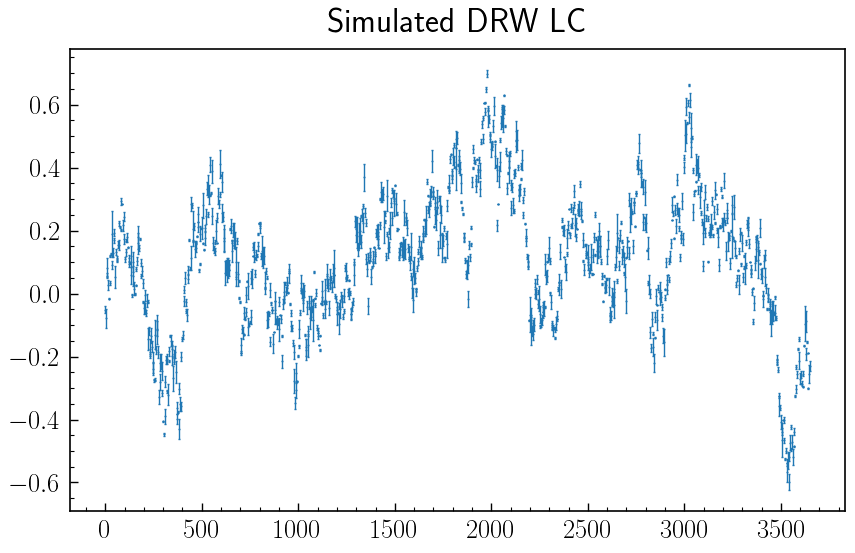

In [6]:
simTerm = DRW_term(np.log(0.3), np.log(200))
t, y, yerr = gpSimFull(simTerm, 15, 3650, 1000, nLC=1)

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.errorbar(t[0], y[0], yerr[0], fmt='.', markersize=1, linewidth=1, capsize=1)
plt.title('Simulated DRW LC')

#### 1.2 Try with DHO term

Text(0.5, 1.0, 'Simulated DHO LC')

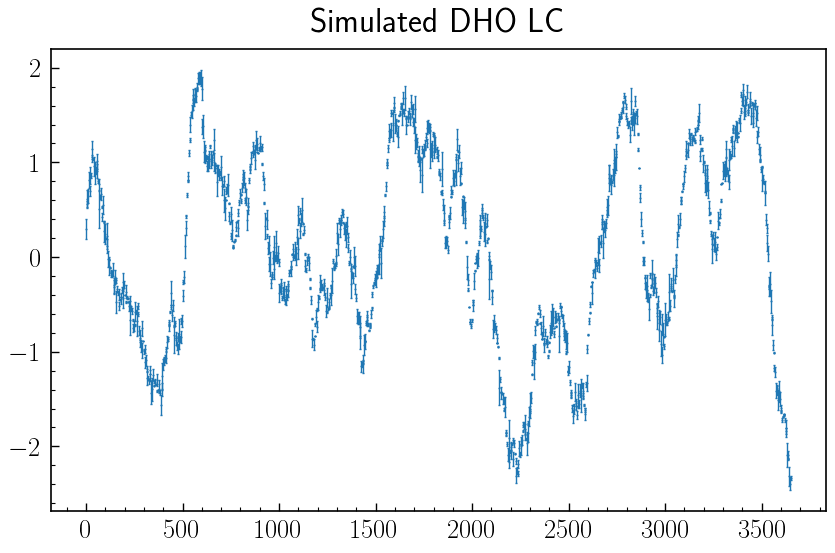

In [7]:
# define GP model
a1 = 0.03939692
a2 = 0.00027941
b0 = 0.0046724
b1 = 0.0256982
DHO_kernel = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
t, y, yerr = gpSimFull(DHO_kernel, 15, 3650, 1000)

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.errorbar(t[0], y[0], yerr[0], fmt='.', markersize=1, linewidth=1, capsize=1)
plt.title('Simulated DHO LC')

#### 1.3 Try with CARMA(2,0)

Text(0.5, 1.0, 'Simulated SHO/QPO LC')

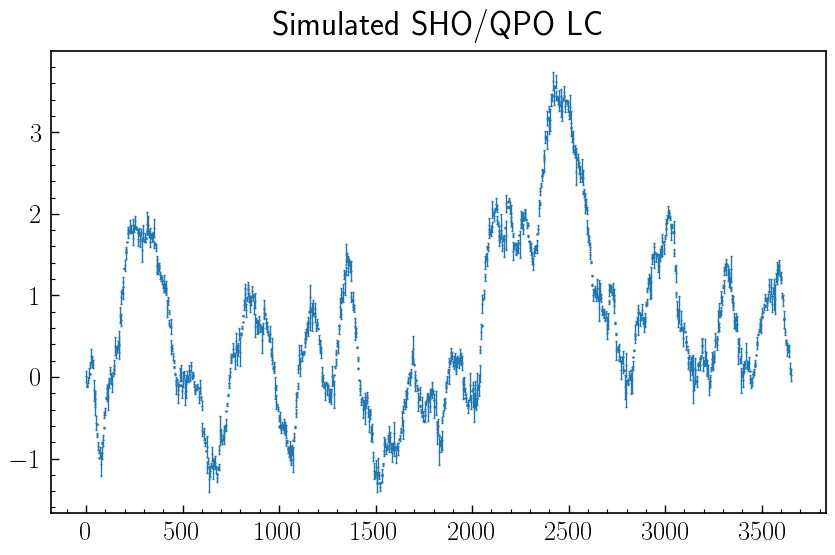

In [8]:
SHO_kernel = CARMA_term(np.log([a1, a2]), np.log([b0]))
t, y, yerr = gpSimFull(SHO_kernel, 15, 3650, 1000)

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.errorbar(t[0], y[0], yerr[0], fmt='.', markersize=1, linewidth=1, capsize=1)
plt.title('Simulated SHO/QPO LC')

### 2. LC Sim (Randomly Downsampled)
Inputs:
- CARMA term
- SNR
- duration
- final N
- seasonal gap (optional)

In [9]:
def gpSimRand(carmaTerm, SNR, duration, N, nLC=1, season=True, full_N = 10_000):

    assert isinstance(carmaTerm, celerite.celerite.terms.Term), \
            'carmaTerm must a celerite GP term'
    
    t, y, yerr = gpSimFull(carmaTerm, SNR, duration, full_N, nLC=nLC)
    
    # output t & yerr
    t_out = np.empty((nLC, N))
    y_out = np.empty((nLC, N))
    yerr_out = np.empty((nLC, N))

    # downsample
    for i in range(nLC):
        mask1 = add_season(t[i])
        mask2 = downsample_byN(t[i, mask1], N)
        t_out[i, :] = t[i, mask1][mask2]
        y_out[i, :] = y[i, mask1][mask2]
        yerr_out[i, :] = yerr[i, mask1][mask2]

    return t_out, y_out, yerr_out

#### 2.1 Try with a DRW term

Text(0.5, 1.0, 'Simulated DRW LC (150 data points)')

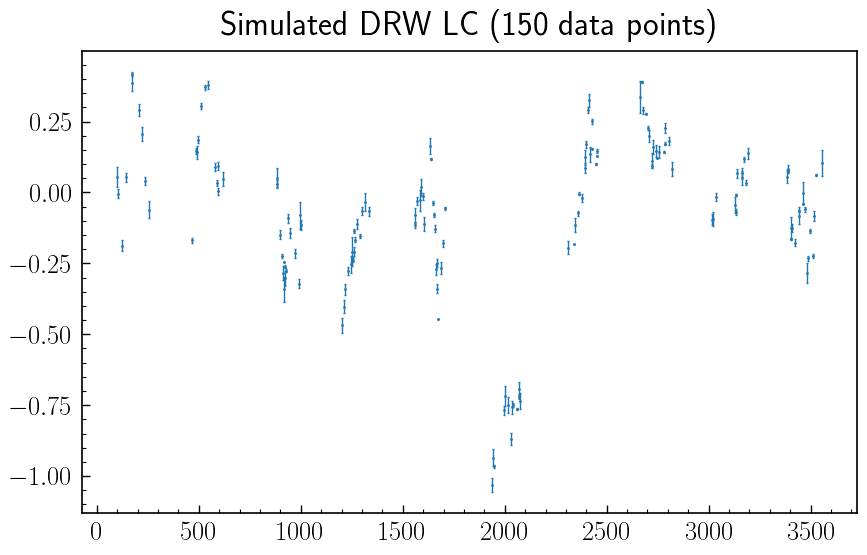

In [10]:
downN = 150
simTerm = DRW_term(np.log(0.3), np.log(200))
t, y, yerr = gpSimRand(simTerm, 15, 3650, downN)

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.errorbar(t[0], y[0], yerr[0], fmt='.', markersize=2, linewidth=1, capsize=1)
plt.title(f'Simulated DRW LC ({downN} data points)')

#### 2.2 Try with DHO term

Text(0.5, 1.0, 'Simulated DHO LC (150 data points)')

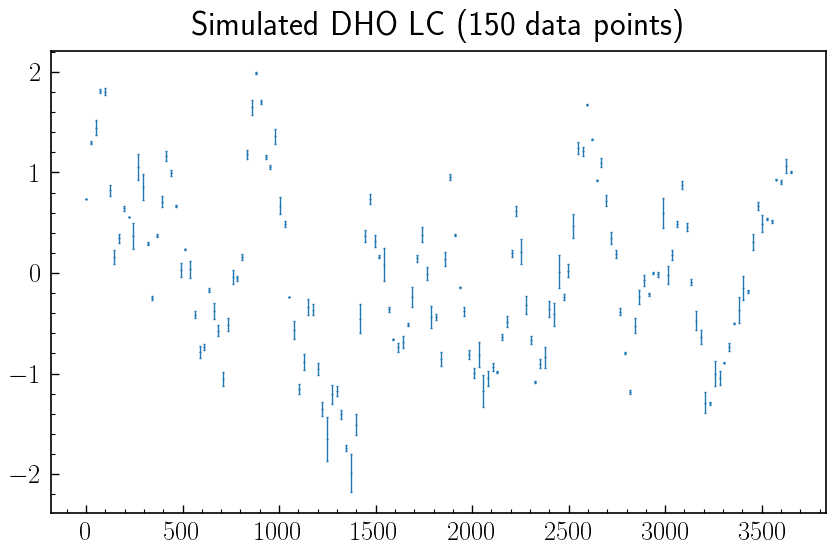

In [11]:
# define GP model
a1 = 0.03939692
a2 = 0.00027941
b0 = 0.0046724
b1 = 0.0256982
DHO_kernel = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
t, y, yerr = gpSimFull(DHO_kernel, 15, 3650, downN)

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.errorbar(t[0], y[0], yerr[0], fmt='.', markersize=1, linewidth=1, capsize=1)
plt.title(f'Simulated DHO LC ({downN} data points)')

#### 2.3 Try with CARMA(2,0)

Text(0.5, 1.0, 'Simulated SHO/QPO LC (150 data points)')

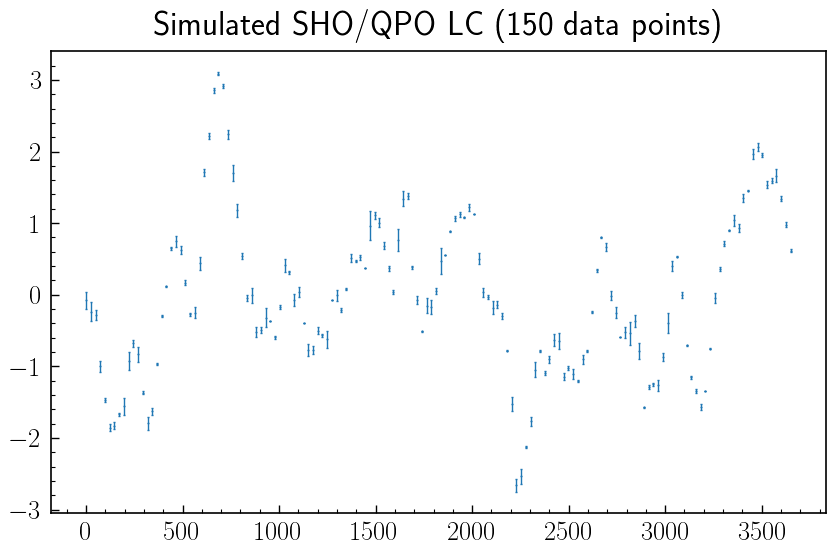

In [12]:
SHO_kernel = CARMA_term(np.log([a1, a2]), np.log([b0]))
t, y, yerr = gpSimFull(SHO_kernel, 15, 3650, downN)

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.errorbar(t[0], y[0], yerr[0], fmt='.', markersize=1, linewidth=1, capsize=1)
plt.title(f'Simulated SHO/QPO LC ({downN} data points)')